# Recreating "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning" with Tensorflow

I am going to derive all the fine details and show code examples based on the paper by Gal and Ghahramani (https://arxiv.org/pdf/1506.02142.pdf) entitled "Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning." Gal and Ghahramani propose that neural networks that employee dropout regularization contain additional, valuable, information about the certainty of the neural network outputs.  

The main ideas we will be exploring is:

-A neural network can be shown to be approximately a Gaussian process.

-The predictive distribution over the Bayesian posterior can be approximately integrated over via MC sampling.

-The sampling is mathematically equivalent to dropout methods in combination with variational inference.  

below I will show all the details of each point and provide some code examples where appropriate.


## Review of Gaussian Processes

What is a Gaussian process?  Typically in most data science problems we are given some data and asked to model the data, with some approximation function that we assume generated the data of the form

$Y \approx \hat{y}(X)$

where $Y$ and $\hat{y}(X)$ are in general tensors, but we will restrict our view such that $X$ is a matrix (rank-2 tensor) of $R$ observations of $V$ features such that dim$(X)= R \times V$. Through out this document I will denote observations/rows by latin indices $(i,j,k,...)$ and variables/features will be denoted by greek indices $(\mu,\nu,\rho,...)$.

I restrict $Y$ to $R \times D$ where $D$ is the dimensionality of the output (a $D \times 1$ vector) for each record $R$, such that the previous expression in elemental form is

$y_{n\nu} \approx \hat{y}(x_{n1},x_{n2},...,x_{nV})$

Typically our choice of approximation comes with some parameters $\Theta$ ie some values to fit to the data that give the "best" approximation or approximate solution to the equation above.  

$Y \approx \hat{y}(X|\Theta)$

These parametric function approximators restrict you to a class of functions (e.g. linear, polynomial, etc.) while we impose these restrictions from some other notion that we should be using that class of functions.  What a Gaussian process proposes is, rather than selecting a class of functions we ask, if the data were generated from some stochastic function whose values are distributed like a multivariate Gaussian. What would be the distribution of possible values for that function at an unobserved point, $x^*$? We are assuming our data is a sampling of a stochastic function where the probability density functional of the stochastic function is given as

$P[f|0,K(x,x')] \propto \exp\left( -\frac{1}{2}\int \int \sum_{\mu,\nu = 1}^D f^\mu(x) K^{-1}_{\mu\nu}(x,x') f^\nu(x') dx dx'\right)$

We choose the form of the covariance function $K(x,x')$ which is our prior belief of the smoothness of the possible stochastic function realizations (covariance between successive points determines function smoothness).  If we ask what is the probability of observing our dataset given this model we can express it as

$P[f_*,f|0,K]  = Z \exp\left( -\frac{1}{2} \sum_{i,j=1}^R \sum_{\nu,\mu=1}^D f^\nu_i \Lambda^{ij}_{\nu\mu} f^\mu_j - \sum_{\mu,\nu=1}^D f^\mu_* \sum_{i=1}^R  \Lambda^{*i}_{\mu\nu}f^\nu_i -\frac{1}{2} \sum_{\nu,\mu=1}^D f^\mu_* \Lambda^{**}_{\mu\nu} f^\nu_* \right)$

were $\Lambda^{ij}_{\mu\nu} = \left(K^{-1}\right)_{\mu\nu}^{ij}$, $K^{ij}_{\mu\nu} = K_{\mu\nu}(x_i,x_j)$, $K_{\mu\nu}^{*i} = K_{\mu\nu}(x_*,x_i)$, $K_{\mu\nu}^{**}=K_{\mu\nu}(x_*,x_*)$ with similar notation for $\Lambda$. This leads to

$P[f_*|f,0,K] = \frac{P[f_*,f|0,K]}{P[f|0,K]} = \frac{P[f_*,f|0,K]}{\int df_* P[f_*,f|0,K]}$

$\lambda_\mu = \sum_{\nu=1}^D \sum_{i=1}^R \Lambda_{\mu\nu}^{*i} f^\nu_i$

$P[f_*,f|0,K] = Z \exp\left( -\frac{1}{2} \sum_{i,j=1}^R  \sum_{\mu,\nu=1}^D f^\mu_i \Lambda^{ij}_{\mu\nu} f^\nu_j \right) \exp\left(-\frac{1}{2} \sum_{\mu,\nu=1}^D f^\mu_* \Lambda_{\mu\nu}^{**} f^\nu_* - \sum_{\mu=1}^D \lambda_\mu f^\mu_* \right)$

$\int df_* P[f_*,f|0,K] \propto  \exp\left( -\frac{1}{2} \sum_{i,j=1}^R \sum_{\mu,\nu=1}^D f^\mu_i \Lambda^{ij}_{\mu\nu} f^\nu_j \right)$

$P[f_*|f,0,K] \propto \exp\left(-\frac{1}{2} \sum_{\mu,\nu=1}^D f^\mu_* \Lambda^{**}_{\mu\nu} f^\nu_* - \sum_{\mu=1}^D \lambda_\mu f^\mu_* \right) $

$-\frac{1}{2} \sum_{\mu,\nu=1}^D f^\mu_* \Lambda^{**}_{\mu\nu} f^\nu_*- \sum_{\mu=1}^D \lambda_\mu f^\mu_*  = -\frac{1}{2} \sum_{\mu,\nu=1}^D (f^\mu_*-m^\mu) \Lambda'_{\mu\nu} (f^\nu_*-m^\nu)+\frac{1}{2} \sum_{\nu,\mu=1}^D m^\mu \Lambda'_{\mu \nu} m^\nu$

$\sum_{\mu,\nu=1}^D f^\mu_* \Lambda^{**}_{\mu\nu} f^\nu_* + 2 \sum_{\nu,\mu=1}^D \sum_{i=1}^R f^\mu_* \Lambda^{*i}_{\mu\nu} f^\nu_i = \sum_{\nu,\mu=1}^D f^\mu_* \Lambda'_{\mu \nu} f^\nu_* - 2 \sum_{\nu,\mu=1}^D m^{\nu} \Lambda'_{\nu \mu} f^\mu_*$

leads to the identification of

$\Lambda'_{\mu \nu} = \Lambda^{**}_{\mu \nu}$

$\sum_{\nu,\mu=1}^D \sum_{i=1}^R f^\mu_* \Lambda^{*i}_{\mu\nu} f^\nu_i  = -\sum_{\nu,\mu=1}^D m^{\nu} \Lambda'_{\nu \mu} f^\mu_* = -\sum_{\nu,\mu=1}^D m^{\nu} \Lambda^{**}_{\nu \mu} f^\mu_*$

$m^{\rho} = -\sum_{\rho,\mu,\nu = 1}^D \sum_{i=1}^R ((\Lambda^{**})^{-1})_{\rho \mu}^T \Lambda^{*i}_{\mu \nu} f^\nu_i$

if we select only kernels where $K^T_{\mu\nu} = K_{\mu\nu}$ then the inverses wrt the variable dimensions will also be transpose invariant, thus

$m^{\rho} = -\sum_{\rho,\mu,\nu = 1}^D \sum_{i=1}^R ((\Lambda^{**})^{-1})_{\rho \mu} \Lambda^{*i}_{\mu \nu} f^\nu_i$

If we express this all in terms of matrix vector notation where we drop the variable dimensions (greek indices) with underline denoting the dropping of the variable dimensions we have

$\underline{\Lambda}' = \underline{\Lambda}^{**}$

$\underline{m} = - \sum_{i=1}^R (\underline{\Lambda^{**}})^{-1} \underline{\Lambda^{*i}} \  \underline{f}_i$

and therefore

$P[\underline{f}_*| \underline{f},0,\underline{K}] = N \left[ \underline{m},(\underline{\Lambda^{**}})^{-1} \right]$

where the inverse is with respect to the greek indices.

## Expressing The Result in Familiar Terms

We can express $\boldsymbol{m}$ and $(\underline{\Lambda^{**}})^{-1}$ in terms of $\underline{K}$ by using the inverse identity

$\sum_{\nu=1}^D \sum_{m=1}^{R+1} \Lambda_{\mu\nu}^{im} K^{mj}_{\nu\rho} = \delta_{\mu\rho} \delta^{ij}$

which can be decomposed into 4 cases

Case 1: $i = j = x^*$

$ \sum_{\nu=1}^D \Lambda_{\mu\nu}^{**} K^{**}_{\nu\rho} + \sum_{\nu=1}^D \sum_{m=1}^{R} \Lambda_{\mu\nu}^{*m} K^{m*}_{\nu\rho} = \delta_{\mu\rho}$

Case 2: $i \neq j = x^*$

$ \sum_{\nu=1}^D \Lambda_{\mu\nu}^{i*} K^{**}_{\nu\rho} + \sum_{\nu=1}^D \sum_{m=1}^{R} \Lambda_{\mu\nu}^{im} K^{m*}_{\nu\rho} = 0$

Case 3: $j \neq i = x^*$

$ \sum_{\nu=1}^D \Lambda_{\mu\nu}^{**} K^{*j}_{\nu\rho} + \sum_{\nu=1}^D \sum_{m=1}^{R} \Lambda_{\mu\nu}^{*m} K^{mj}_{\nu\rho} = 0$

Case 4: $i,j \neq x^*$

$ \sum_{\nu=1}^D \Lambda_{\mu\nu}^{i*} K^{*j}_{\nu\rho} + \sum_{\nu=1}^D \sum_{m=1}^{R} \Lambda_{\mu\nu}^{im} K^{mj}_{\nu\rho} = \delta_{\mu\rho} \delta^{ij}$

one can write these cases in block matrix form where 

$\Lambda_{\mu \nu}(x_*,x_i) = \Lambda_{\mu \nu}^{*i} \rightarrow \boldsymbol{\Lambda}_{\mu\nu}^{*.}$, rank-3 tensor

$\Lambda_{\mu \nu}(x_*,x_*) = \Lambda_{\mu \nu}^{**} \rightarrow \Lambda_{\mu\nu}^{**}$, rank-2 tensor

$\Lambda_{\mu \nu}(x_i,x_j) = \Lambda_{\mu \nu}^{ij} \rightarrow \boldsymbol{\Lambda}_{\mu \nu}^{..}$, rank-4 tensor

where $i,j \in [1,R]$ and bold facing indices suppression of the observation(latin) indices,

$ \sum_{\nu=1}^D
\begin{bmatrix}
    \boldsymbol{\Lambda}_{\mu\nu}^{..} & \boldsymbol{\Lambda}_{\mu\nu}^{*.} \\
    \boldsymbol{\Lambda}_{\mu\nu}^{.*} & \Lambda_{\mu\nu}^{**}
\end{bmatrix}
\begin{bmatrix}
    \boldsymbol{K}_{\nu\rho}^{..} & \boldsymbol{K}_{\nu\rho}^{*.} \\
    \boldsymbol{K}_{\nu\rho}^{.*} & K_{\nu\rho}^{**}
\end{bmatrix}
=
\begin{bmatrix}
    \delta_{\mu\rho} \times \boldsymbol{1} & \boldsymbol{0} \\
    \boldsymbol{0} & \delta_{\mu\rho}
\end{bmatrix}
$

which gives the system of equations corresponding to the cases I outlined above

$\sum_{\nu=1}^D\left( \Lambda_{\mu\nu}^{**} K_{\nu\rho}^{**} + \boldsymbol{\Lambda}_{\mu\nu}^{.*} \boldsymbol{K}_{\nu\rho}^{*.}\right) = \delta_{\mu \rho}$ 

$\sum_{\nu=1}^D\left( \boldsymbol{\Lambda}_{\mu\nu}^{*.} K_{\nu\rho}^{**}+ \boldsymbol{\Lambda}_{\mu\nu}^{..}\boldsymbol{K}_{\nu\rho}^{*.}\right) = \boldsymbol{0}$

$\sum_{\nu=1}^D\left( \Lambda_{\mu\nu}^{**} \boldsymbol{K}_{\nu\rho}^{.*} + \boldsymbol{\Lambda}_{\mu\nu}^{.*} \boldsymbol{K}_{\nu\rho}^{..}\right) = \boldsymbol{0}$

$\sum_{\nu=1}^D \left( \boldsymbol{\Lambda}_{\mu\nu}^{*.} \boldsymbol{K}_{\nu\rho}^{.*} + \boldsymbol{\Lambda}_{\mu\nu}^{..}\boldsymbol{K}_{\mu\rho}^{..} \right)  = \delta_{\mu \rho} \times \boldsymbol{1}$

### Sanity Check
If we assume $D = 1$ then all of greek indices are fixed and we can drop them. In this case,
$\Lambda_{\mu\nu}^{**} = \Lambda^{**}$ a scalar, $\boldsymbol{\Lambda}_{\mu\nu}^{.*}=\boldsymbol{\Lambda}^{.*}$ a vector, $\boldsymbol{\Lambda}_{\mu\nu}^{..}=\boldsymbol{\Lambda}^{..}$ a matrix. Does each equation have the right dimensions?

scalar-
$\Lambda^{**} K^{**} + (\boldsymbol{\Lambda}^{*.})^T \cdot (\boldsymbol{K}^{.*})^T = 1$ 

vector-
$ K^{**} \boldsymbol{\Lambda}^{*.} + \boldsymbol{\Lambda}^{..} \cdot (\boldsymbol{K}^{.*})^T = \boldsymbol{0}$

vector-
$ \Lambda^{**} (\boldsymbol{K}^{*.})^T + (\boldsymbol{\Lambda}^{*.})^T \cdot \boldsymbol{K}^{..} = \boldsymbol{0}$

matrix-
$ \boldsymbol{\Lambda}^{*.} \cdot \boldsymbol{K}^{.*} + \boldsymbol{\Lambda}^{..} \cdot \boldsymbol{K}^{..} = \boldsymbol{1}$

yes all the equations have the right dimensionality, I continue.

### Solving the System of Equations
Our goals are to find $(\underline{\Lambda^{**}})^{-1}$ and $\underline{\Lambda^{*.}}$ which can be given by our system of equations by applying inverses as is done to case 3 below for demonstration

$\sum_{\nu,\rho=1}^D \Lambda_{\mu\nu}^{**} \boldsymbol{K}_{\nu\rho}^{.*}  (\boldsymbol{K}^{.*})^{-1}_{\rho \lambda} = -\sum_{\nu,\rho=1}^D \boldsymbol{\Lambda}_{\mu\nu}^{.*} \boldsymbol{K}_{\nu\rho}^{..}(\boldsymbol{K}^{.*})^{-1}_{\rho \lambda} $

where the inverse on $(\boldsymbol{K}^{.*})^{-1}$ is with respect to the greek indices.  This gives

$\Lambda_{\mu \nu}^{**}  = -\sum_{\lambda,\kappa=1}^D \boldsymbol{\Lambda}_{\mu\lambda}^{.*} \boldsymbol{K}_{\lambda \kappa}^{..}(\boldsymbol{K}^{.*})^{-1}_{\kappa \nu} $

substituing this into case 1,

$\sum_{\lambda=1}^D\ \boldsymbol{\Lambda}_{\mu\lambda}^{.*} \left( \boldsymbol{K}_{\lambda\rho}^{*.} -\sum_{\nu,\kappa=1}^D  \boldsymbol{K}_{\lambda \kappa}^{..}(\boldsymbol{K}^{.*})^{-1}_{\kappa \nu} K_{\nu\rho}^{**} \right)  = \delta_{\mu \rho}$ 

$\boldsymbol{\Lambda}_{\lambda \rho}^{.*} = (\boldsymbol{K}_{\lambda\rho}^{*.} -\sum_{\nu,\kappa=1}^D  \boldsymbol{K}_{\lambda \kappa}^{..}(\boldsymbol{K}^{.*})^{-1}_{\kappa \nu} K_{\nu\rho}^{**})^{-1}$

where the inverse is taken with respect to the greek indices above.  Finding the inverse of $\Lambda_{\mu \nu}^{**}$ is best calculated by looking at the case where $D=1$ and we drop the greek indices,

$\Lambda^{**} = -( \sum_{i,j=1}^R \Lambda^{i*} K^{ij} (K^{j*})^{-1})$

$1 = - \left( \sum_{i,j=1}^R \Lambda^{i*} K^{ij} \frac{1}{K^{j*}} \right) (\Lambda^{**})^{-1}$

$= - \left( \sum_{i,j=1}^R \Lambda^{i*} K^{ij} \frac{1}{K^{j*}} \right) (K^{*j} (K^{-1})^{jl} \frac{1}{\Lambda^{i*}})$


$ \left( \Lambda^{**} \right)^{-1} = \sum_{i,j=1}^R K^{*i} (K^{-1})^{ij} \frac{1}{\Lambda^{j*}}$

$= \boldsymbol{K}^{*.} (\boldsymbol{K}^{..})^{-1} (\boldsymbol{\Lambda}^{.*})^{-1}$


where in this case $(\boldsymbol{K}^{..})^{-1}$ is the inverse is with respect to latin indices!

$= -\sum_{\lambda,\kappa=1}^D \boldsymbol{K}^{.*}_{\nu \kappa} (\boldsymbol{K}^{..})^{-1}_{\kappa \lambda} (\boldsymbol{K}_{\lambda\mu}^{*.} -\sum_{\phi,\rho=1}^D  \boldsymbol{K}_{\lambda \rho}^{..}(\boldsymbol{K}^{.*})^{-1}_{\rho \phi} K_{\phi\mu}^{**})$

$= K_{\mu \nu}^{**}-\sum_{\lambda,\kappa=1}^D \boldsymbol{K}^{.*}_{\nu \kappa} (\boldsymbol{K}^{..})^{-1}_{\kappa \lambda} \boldsymbol{K}_{\lambda\mu}^{*.}$

and finally after all these indices we have

$m_{\rho} = \sum_{\kappa,\nu = 1}^D \boldsymbol{K}^{.*}_{\rho \kappa} (\boldsymbol{K}^{..})^{-1}_{\kappa \nu} f^\nu_. \rightarrow \sum_{i,j=1}^R \sum_{\kappa,\nu = 1}^D \boldsymbol{K}^{i*}_{\rho \kappa} (\boldsymbol{K}^{ij})^{-1}_{\kappa \nu} f^\nu_j$


$P[f_*|f,0,K] = N\left( \ \sum_{\kappa,\nu = 1}^D \boldsymbol{K}^{.*}_{\rho \kappa} (\boldsymbol{K}^{..})^{-1}_{\kappa \nu} \boldsymbol{f}^\nu_. ,\  K_{\mu \nu}^{**}-\sum_{\lambda,\kappa=1}^D \boldsymbol{K}^{.*}_{\nu \kappa} (\boldsymbol{K}^{..})^{-1}_{\kappa \lambda} \boldsymbol{K}_{\lambda\mu}^{*.} \right)$

The simplest case is when $D=1$ where we have

$P[f_*|f,0,K] = N\left( \ \sum_{i,j=1}^R \boldsymbol{K}^{*i} (\boldsymbol{K}^{-1})^{ij} \boldsymbol{f}^\nu_j ,\  K^{**}- \sum_{i,j=1}^R \boldsymbol{K}^{*i} (\boldsymbol{K}^{-1})^{ij} \boldsymbol{K}^{j*} \right)$

## Measurement/Precision Error

To make things easier from here on I assume $D = 1$ unless otherwise specified but all similar results can be derived for larger dimensions. We can easily incorporate measurement error by assuming that the measurement of $f$ from the true Gaussian process is given by

$y_i = f_i + \epsilon_i, \ \epsilon_i \sim N(0,\sigma^2)$

such that the likelihood of our observations can be expressed as

$P(y_*,Y|X) = \int df_1 df_2...df_R df_* \ P(y_*,Y|f,X) P(f|X)$

$P(y_*,Y|X) \propto \int df_* df_1...df_R \ \exp\left(-\frac{1}{2\sigma^2}(y_* - f_*)^2\right)\exp\left( -\frac{1}{2\sigma^2}\sum^R_i(y_i - f_i)^2  \right) \exp\left(-\frac{1}{2} \sum_{i,j} f_i \Lambda_{ij} f_j \right) \exp\left(- f_* \sum_i \Lambda_{*i}f_i -\frac{1}{2} f_* \Lambda_{**} f_*\right)$


$P(y_*,Y|X) \propto \int df_1...df_{R+1} \exp\left( -\frac{1}{2\sigma^2}\sum^{R+1}_i(y_i - f_i)^2  \right)\exp\left(-\frac{1}{2} \sum^{R+1}_{i,j} f_i \Lambda_{ij} f_j \right)$

$ = \int dF \exp\left( -\frac{1}{2\sigma^2} (y-f)^T(y-f) \right) \exp\left( -\frac{1}{2} f^T \Lambda f \right)$

$ = \int dF \exp\left( -\frac{1}{2\sigma^2}y^T y \right) \exp\left( -\frac{1}{2} f^T \left( \frac{1}{\sigma^2} + \Lambda \right) f + \frac{1}{\sigma^2} y^T f \right)$

$\propto \exp \left( -\frac{1}{2\sigma^2} y^T \left(1-\left( 1 + \sigma^2 \Lambda \right)^{-1} \right) y^T  \right)$

$\left(1-\left( 1 + \sigma^2 \Lambda \right)^{-1} \right) = \left(1-\left( 1 + \sigma^2 K^{-1} \right)^{-1} \right) = \sigma^2(\sigma^2+K)^{-1}$

thus

$P(y_*,Y|X) \propto \exp \left( -\frac{1}{2} y^T \left(\sigma^2+K \right)^{-1} y \right)$

Therefore the previous derivation is the same for $P(y_*|Y,X)$ with the modification of

$K(x,x') \rightarrow K(x,x') + \sigma^2 I(x,x')$

where $I(x,x') = 0, \ x \neq x'$ and $I(x,x) = 1$


## Code: Gaussian Process Example

Lets see an example of this work in practice.  I will fit a Gaussian process to a data set using a radial basis function kernel (rbf) function and linear distance function. The RBF and linear function has one free parameter  $\alpha$ and the Euclidean distance is used within the RBF and linear function below, 

$K_{rbf}(x_i,x_j) = \exp(-\alpha ||x_i-x_j||^2)$

$K_{lin}(x_i,x_j) = ||x_i - x_j||^2 + \alpha$

In this example I select dim$(x_i) = 1$ and dim$(y_i) = 1$ so there is need for the greek indices in this case.  Our results collapse to

$m(x_*) = \sum_{i,j=1}^R K(x_*,x_i)K(x_i,x_j)^{-1}f_j$ 

Var$(x_*) = K(x_*,x_*)-\sum_{i,j=1}^R K(x_*,x_i) K(x_i,x_j)^{-1} K(x_j,x_*)$

Let's compute these results below

In [307]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")

In [308]:
# Number of records R
R = 10

np.random.seed(42)

# our sample data points of x
# we take R, 1 by 1 measures for our features
X = 10*np.random.random(R)

# our sample of data points f
# we take R, 1 by 1 values for our observations
F = np.sin(X)

# define our prior believe of a smoothing function
# for our Gaussian process
def K_RBF(x_1, x_2, alpha=0.1):
    return np.exp(-alpha*(x_1-x_2)**2)

def K_linear(x_1, x_2, alpha = 1.):
    return np.abs(x_1-x_2) + alpha

In [309]:
# Smoothness parameter
alpha = 1.5;
l = 1.;

# Computing our K matrices K_{..} = K(x_i,x_j)
K_rbf = np.array([ K_RBF(X,xp,alpha) for xp in X])
K_lin = np.array([ K_linear(X,xp,l) for xp in X]) 

In [310]:
# we are going repeat the calculation of m(x_*) and var(x_*)
# for an array of points which fall between the observed measures
# and a little beyond it
X_star = np.linspace(0,12,100)

In [311]:
# Computing our m(x_*) value for each X_star value
# m_* = - K_{*.} K_{..}^{-1} F
K_rbf_star = np.array([ K_RBF(xs,X,alpha) for xs in X_star])
K_lin_star = np.array([ K_linear(xs,X,l) for xs in X_star])

K_rbf_inv = np.linalg.inv(K_rbf)
K_lin_inv = np.linalg.inv(K_lin)

m_rbf = np.dot(np.matmul(K_rbf_star, K_rbf_inv), F)
m_lin = np.dot(np.matmul(K_lin_star, K_lin_inv), F)

In [312]:
# Computing our variance matrix
# Var(x_*) = K_{**} - K_{*.} K^{-1}_{..} K_{.*}
var_rbf = np.abs( np.diag( np.eye(len(X_star)) - np.matmul(K_rbf_star, np.matmul(K_rbf_inv,K_rbf_star.T)) ) )
var_lin = np.abs( np.diag( np.eye(len(X_star)) - np.matmul(K_lin_star, np.matmul(K_lin_inv,K_lin_star.T)) ) )

In [313]:
std_rbf = np.sqrt(var_rbf)
std_lin = np.sqrt(var_lin)

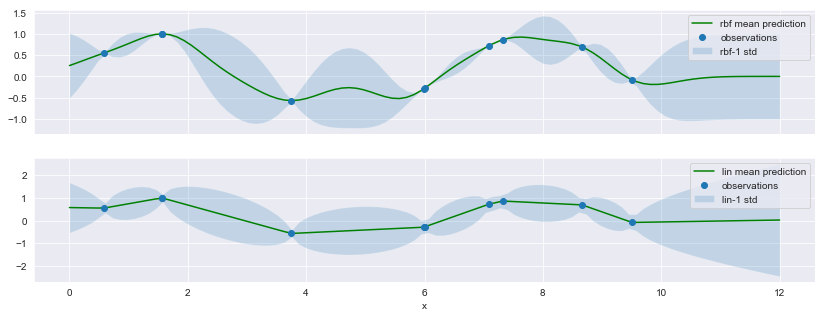

In [314]:
fig, ax = plt.subplots(2, sharex=True,figsize=(14, 5))

ax[0].fill_between(X_star, m_rbf + std_rbf, m_rbf - std_rbf, alpha=0.2, label='rbf-1 std')
ax[0].plot(X_star, m_rbf, linestyle="-", color='green', label='rbf mean prediction')

ax[1].fill_between(X_star, m_lin + std_lin, m_lin - std_lin, alpha=0.2, label='lin-1 std')
ax[1].plot(X_star, m_lin, linestyle="-", color='green', label='lin mean prediction')

ax[0].plot(X,F, marker='o', linestyle='', label='observations')
ax[1].plot(X,F, marker='o', linestyle='', label='observations')

plt.xlabel('x')

ax[0].legend()
ax[1].legend()

plt.show()

In [315]:
# Including Measurement Error with the Indicator function I(x,x')
def I(x_1,x_2):
    return x_1 == x_2

# packaging up all the GP steps into a function
def GP_regression(X,F, alpha, measure_error=0.):
    # Computing our K matrix K_{..} = K(x_i,x_j)
    K = np.array([ (K_func(X,xp,alpha)+measure_error*I(X,xp)) for xp in X])
    X_star = np.linspace( X.min()*(0.9),X.max()*(1.1),100)
    K_star = np.array([ K_func(xs,X,alpha) for xs in X_star])
    K_inv = np.linalg.inv(K)
    m = np.dot(np.matmul(K_star, K_inv), F)
    var = np.abs( np.diag( np.eye(len(X_star)) - np.matmul(K_star, np.matmul(K_inv,K_star.T)) ) )
    std = np.sqrt(var)
    
    return(X_star,m,std)

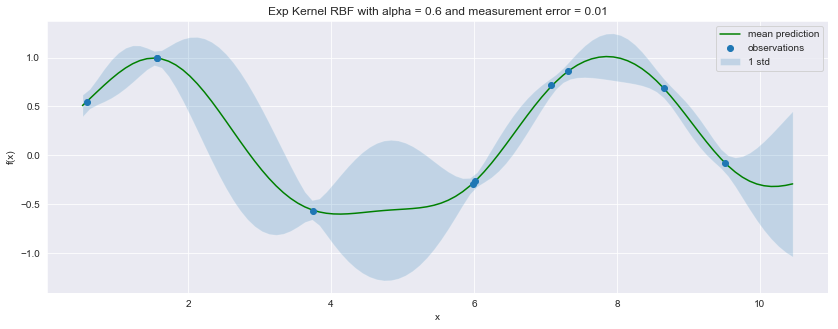

In [316]:
# sample data fit but now we assume some measurement error
fig, ax = plt.subplots(figsize=(14, 5))

Xs,m,std = GP_regression(X,F,0.6,0.01)

plt.fill_between(Xs, m + std, m - std, alpha=0.2, label='1 std')
plt.plot(Xs,m,linestyle="-",color='green',label='mean prediction')
plt.plot(X,F, marker='o',linestyle='',label='observations')

plt.title('Exp Kernel RBF with alpha = 0.6 and measurement error = 0.01')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

plt.show()

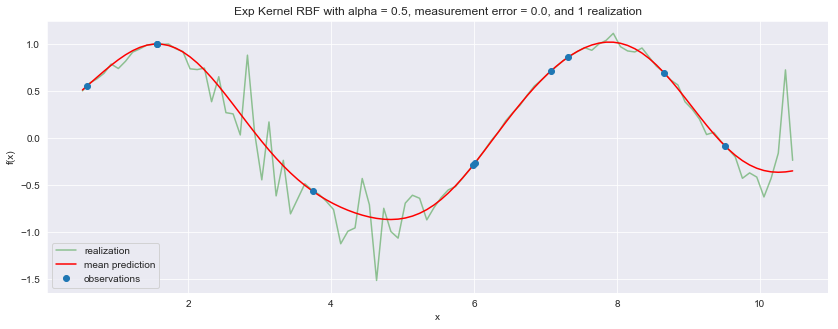

In [317]:
# Just for completeness, given the observations
# I will generate a possible GP realization that
# is consistant with the observations
Xs,m,std = GP_regression(X,F,0.5,0)

#generate realizations
realizations = 1
samples = [m + std*np.random.randn(len(m)) for _ in range(realizations)]

fig, ax = plt.subplots(figsize=(14, 5))

# ploting realizations
for samp in samples:
    plt.plot(Xs, samp,color='green',linestyle="-",alpha=0.4,label='realization')
    
plt.plot(Xs,m,linestyle="-",color='red',label='mean prediction')
plt.plot(X,F, marker='o',linestyle='',label='observations')

plt.title('Exp Kernel RBF with alpha = 0.5, measurement error = 0.0, and 1 realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

plt.show()

te how changing the kernel function changes the uncertainty curves, this will also be true when we apply these methods to neural networks.


## Adding A Bayesian Prior to a Gaussian Process

Note that above $\alpha$ is set to some fixed value that we believe is representative of the smoothness of the possible processes that the Gaussian process (GP) we are observing actually possess.  Of course we do not need to fix $\alpha$ but rather we could put a prior distribution of our belief of possible $\alpha$ values in the form of $p(\alpha)$, in this case our GP takes the form
 
$P(y|X) \propto \int N(y|0,\sigma^2 I_R + K(X,X|\alpha))p(\alpha) d\alpha = \int \exp \left( -\frac{1}{2} y^T \left(\sigma^2+K(X,X|\alpha) \right)^{-1} y \right) p(\alpha) d\alpha$
 
In general calculating the right hand side is going to be difficult for different selections of $p(\alpha)$.  However we can use 

$\int dx \exp(-f(x)) = \int dx \exp(-f(x^+)) \exp( -f'(x^+) x ) \exp( -f''(x^+)/2 (x-x^+)^2) O( f'''(x^+) )$

$ \propto e^{-f^+}, \ f'(x^+) = 0$

to approximate the solution using,

$f(\alpha) = \frac{1}{2} y^T \left(\sigma^2+K(X,X|\alpha) \right)^{-1} y - \log [p(\alpha)]$ 

gives

$P(y|X) \approx \frac{1}{Z} \exp \left( -\frac{1}{2} y^T \left(\sigma^2+K(X,X|\alpha^+) \right)^{-1} y \right)$


thus, so long as $f'''(\alpha^+)$ is small, applying a prior on kernel parameters will still result in a GP.

## Neural Networks are Approximate Gaussian Processes

### Selecting a Special Kernel

If we select a special kernel for a GP we will find some remarkable results.  Let's start with writing the kernel below

$K(x,x') = \int N(w|0,l^2 I_V) p(b) \sigma(w^T x + b) \sigma(w^T x' + b) dw db$

where $\sigma(x)$ is a non-linear, smooth function, $w$ are $V \times 1$ random vectors and $b$ are random scalars.  We are going to approximate the kernel $K(x,x')$ by Monte-Carlo integration expressed as

$\hat{K}(X,X') = \frac{1}{H} \sum_{h=1}^H \sigma(w_h^T x + b_h) \sigma(w_h^T x' + b_h), \ w_h \sim N(0,l^2 I_V), \ b_h \sim p(b)$

where dim$(w) =  V \times 1$, and dim$(b) = 1 \times 1$. When we select $H$ random samples of the $w$ vectors and collect them into a $H \times V$ matrix $W^1 = [w_1, w_2,...,w_H]$ as well as collecting the $H$ random samples of $b$ vectors into a $H \times 1$ vector $b = [b_1,b_2,...,b_H]$.  With this notation we can express the kernel more compactly as is done below

$\hat{K}(x,x') = \frac{1}{H} \sum_{h=1}^H \sigma \left( \sum_{\nu=1}^V w_{h,\nu} x_\nu + b_h \right) \sigma \left( \sum_{\mu=1}^V w_{h,\mu} x'_\mu + b_h \right)$

evaluating the approximate kernel at the observation points $[x_1,x_2,...,x_R]$,

$\hat{K}^{ij} =\hat{K}(x_i,x_j) = \frac{1}{H} \sum_{h=1}^H \sigma \left( \sum_{\nu=1}^V w_{h,\nu} x^i_\nu + b_h \right) \sigma \left( \sum_{\mu=1}^V w_{h,\mu} x^j_\mu + b_h \right)$

relabeling $W^1_{h\nu} = w_{h,\nu}$ gives

$\hat{K}^{ij} =  \sum_{h=1}^H \left( \frac{1}{\sqrt{H}} \sigma \left( \sum_{\nu=1}^V W^1_{h\nu} x^i_\nu + b_h \right) \right) \left( \frac{1}{\sqrt{H}} \sigma \left( \sum_{\mu=1}^V W^1_{h\mu} x^j_\mu + b_h \right) \right)$

then with the identification of

$\Phi^{hi} =  \frac{1}{\sqrt{H}} \sigma \left( \sum_{\nu=1}^V W^1_{h\nu} x^i_\nu + b_h \right)$, dim$(\Phi) = H \times R$

the approximate kernel is given as

$\hat{K}^{ij} = \sum_{h=1}^H (\Phi^T)^{ih} \Phi^{hj} \rightarrow \hat{K} = \Phi^T \Phi$, dim$(K) = R \times R$.

So now our GP model (with including measurement error) can be expressed compactly as

$f|X \sim N(0, \Phi^T \Phi)$

$P(y_*,y|X) \approx \int N[y_*,y|f,\tau^2 I_R] \ N[f|0, \Phi^T \Phi ] \ dF$

where $dF = df_1 df_2 ... df_R$.  Integrating over $f_i$ values as we have done similarly in the previous section gives,

$P(y_*,y|X) \approx N[y_*,y|0,\Phi^T\Phi+\tau^2 I_R ], \ W^1 \sim P(W^1), \ b \sim P(b)$

with $P(W^1) = N(w_1|0,l^2 I_V)N(w_2|0,l^2 I_V)...N(w_H|0,l^2 I_V)$ 

and 

$P(b) = p(b_1)p(b_2)...p(b_H)$

Here $P(y_*,y|X)$ is a stochastic distribution meaning, depending on the realization of $W^1$ and $b$ it will vary from sample to sample.  It will stabilize to the mean $E\left[ P(y_*,y|X) \right]$ wrt to $W^1$ and $b$, as $H \rightarrow \infty$ thus we will fix the GP distribution $P(y_*,y|X)$ to the mean in the large $H$ limit which can be expressed as

$P(y_*,y|X) = \int N[y_*,y|0,\Phi^T\Phi+\tau^2 I_R ] \ P(W^1) \ P(b) \  dW^1 db$

where now $\Phi(x,W^1,b)$ depends on $W^1$ and $b$ as variables rather than realizations. From here on we will absorb $y_*$ into the definition of $y$, and assume the $R$-th observation is $y_*$.  We are going to re-express our result with a mathematical identity.  First note that

$N[y|0,\Phi^T\Phi+\tau^2 I_R ] \propto \exp \left( -\frac{1}{2} \sum_{i,j=1}^R  y_i (\Phi^T\Phi + \tau^2 I_R)_{ij}^{-1} y_j \right)$

We want to express this quantity as an integral over an additional parameter, which is done through the mathematical identity found in Bishop 2006, p. 93 which states, given

$p(x) = N(x|\mu, \Lambda^{-1}), \ p(y|x) = N(y| A x + b, L^{-1})$  where $x$ and $y$ are vectors, then

$p(y) = \int p(y|x) p(x) dx = N(y|A\mu + b , L^{-1} + A \Lambda^{-1} A^T)$

this allows us to introduce a new vector and write, 

$N[y|0,\Phi^T\Phi+\tau^2 I_R ] = \int N(y|\Phi^T W^2, \tau^{2} I_R) \ N(W^2|0,I_H) \ dW^2$

dim$(W^2)=H \times 1$

Finally we have

$P(y|X) = \int N(y|\Phi^T W^2, \tau^{2} I_R) \ N(W^2|0,I_H) \ P(W^1) \ p(b) \ dW^2 dW^1 db$

Lets code this up to see it work

## Code: GP with the Special Kernel

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [6]:
# Generating Data 
np.random.seed(42)

X_true = np.linspace(-1.5,1.5,100)
y_true = np.exp(-(X_true+1.0)**2/2.*2.77) + np.exp(-(X_true-1.0)**2/2.*2.77)

X_noise = np.sort(np.linspace(-1.5,1.5,30) + 0.25*np.random.randn(30))
y_noise = np.exp(-(X_noise+1.0)**2/2.*2.77) + np.exp(-(X_noise-1.0)**2/2.*2.77) + 0.01*np.random.randn(30)

X_true = (X_true-np.mean(X_true))/np.std(X_true)
y_true = (y_true-np.mean(y_true))/np.std(y_true)

y_noise = (y_noise-np.mean(y_noise))/np.std(y_noise)
X_noise = (X_noise-np.mean(X_noise))/np.std(X_noise)

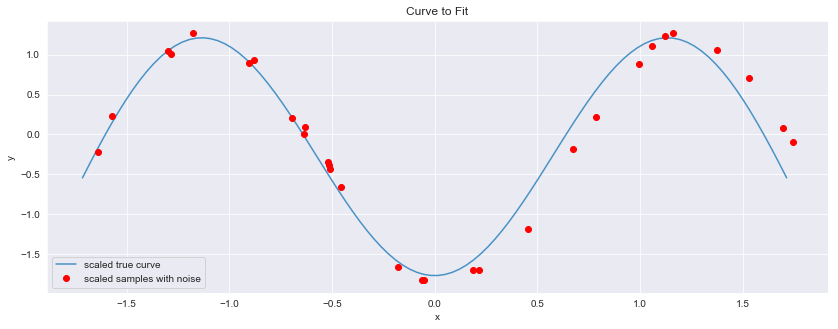

In [7]:
fig = plt.figure(figsize=(14,5))
plt.plot(X_true,y_true, color='#4892C6', linestyle='-', label='scaled true curve')
plt.plot(X_noise,y_noise, color='red', marker='o',linestyle='',label='scaled samples with noise')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve to Fit')
plt.legend()

plt.show()

## Code: Computing the Special Kernel with ReLU

In [10]:
# compute the approximate special kernel H samples
# K_hat = 1/H sum( sigma(w_1*x + b) sigma(w_1*y + b)), w_1 ~ N(0,1), b ~ N(0,1)
H = 100
w1_sample = np.random.randn(H)
b = np.random.randn(H)
tau2 = 1.e-6 # model fixed by operator precision

# vector definition for ReLU
def sigma(x):
    if x < 0.:
        return 0.0
    else:
        return x
    
vsigma = np.vectorize(sigma)

# Computing the Kernel matrix and K_star vector
K_hat = np.array([[np.sum( vsigma( w1_sample*x + b ) * vsigma( w1_sample*xp + b) )/H for x in X_noise] for xp in X_noise])
K_hat = K_hat + tau2*np.eye(len(X_noise))

# Range to predict values under a GP model
X_star = np.linspace( X_noise.min()-1.0,X_noise.max()+1.0,100)
K_star = np.array([[(tau2 if xs==xp else 0.) + np.sum( vsigma( w1_sample*xs + b ) * vsigma( w1_sample*xp + b) )/H for xp in X_noise] for xs in X_star])

# computing m, and variance
K_inv = np.linalg.inv(K_hat)
m = np.dot(np.matmul(K_star, K_inv), y_noise)
var = np.abs( np.diag( np.eye(len(X_star)) - np.matmul(K_star, np.matmul(K_inv,K_star.T)) ) )
std = np.sqrt(var)

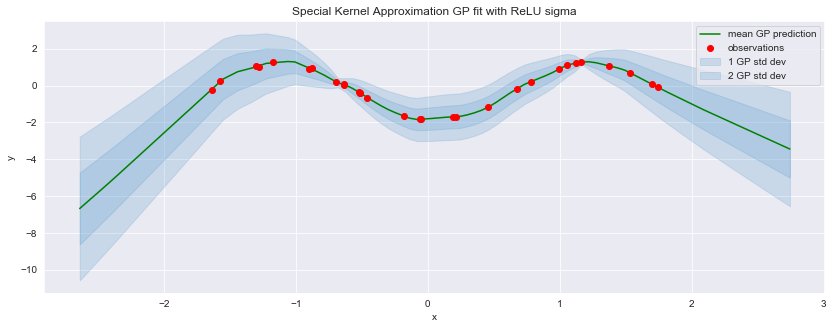

In [12]:
fig = plt.figure(figsize=(14,5))

#variance plots
plt.fill_between(X_star, m + 2.*std, m - 2.*std, color='#4892C6', alpha=0.2, label='1 GP std dev')
plt.fill_between(X_star, m + 1.*std, m - 1.*std, color='#4892C6', alpha=0.2, label='2 GP std dev')

#mean prediction
plt.plot(X_star,m,linestyle="-",color='green',label='mean GP prediction')
#data
plt.plot(X_noise,y_noise, color='red',marker='o',linestyle='',label='observations')

plt.title('Special Kernel Approximation GP fit with ReLU sigma')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

Now to compute the right hand side of our kernel approximation,

$P(y_*,y_1,...y_R|X) \propto \int \exp\left( -\frac{1}{2 \tau^2} (y^*-\Phi_*^T W^2)^2 \right)\exp \left( - \frac{1}{2\tau^2} \sum_{r=1}^R (y_r-\Phi_r^T W^2)^2 \right) \ N(W^2|0,I_H) \ N(W^1|0,I_H) \ N(b|0,1) \ dW^2 dW^1 db$

gives the predictive distribution of

$P(y^*|y,X) = \frac{\int \exp\left( -\frac{1}{2 \tau^2} (y^*-\Phi_*^T W^2)^2 \right)\exp \left( - \frac{1}{2\tau^2} \sum_{r=1}^R (y_r-\Phi_r^T W^2)^2 \right) \ N(W^2|0,I_H) \ N(W^1|0,I_H) \ N(b|0,1) \ dW^2 dW^1 db}{\int \exp \left( - \frac{1}{2\tau^2} \sum_{r=1}^R (y_r-\Phi_r^T W^2)^2 \right) \ N(W^2|0,I_H) \ N(W^1|0,I_H) \ N(b|0,1) \ dW^2 dW^1 db}$

approximating by MC integration gives

$P(y^*|y,X) \approx \frac{\sum_{s=1}^S \exp\left( -\frac{1}{2 \tau^2} (y^*-\Phi_{*,s}^T W_s^2)^2 \right)\exp \left( - \frac{1}{2\tau^2} \sum_{r=1}^R (y_r-\Phi_{r,s}^T W_s^2)^2 \right)}{\sum_{s=1}^S \exp \left( - \frac{1}{2\tau^2} \sum_{r=1}^R (y_r-\Phi_{r,s}^T W_s^2)^2 \right)}, \ W_s^2 \sim N(0,I_H), \ W_s^1 \sim N(0,I_H), \ b_s \sim N(0,1)$

If we look at the form of this distribution we can see that selections of $\omega = {W^1,W^2,b}$ that make $L = \sum_{r=1}^R (y_r-\Phi_{r,s}^T W_s^2)^2$ smallest will contribute the most, so long as the parameters $\omega$ are selected from their distributions.  Given enough data points $R$ there will high tendency to drive the parameters to some optimal value that minimizes $L$, but restricts the possible values to be drawn from their distributions.  Sounds familiar no? Assuming we have these optimal values the expected $y_*$ value will be given by

$E[y^*] \approx \frac{1}{S} \sum_{S=1}^S \Phi_{s,opt}^T W_{s,opt}^2$

and variance given by

Var$(y^*) \approx \tau^{2} + \frac{1}{S} \sum_{S=1}^S (\Phi_{s,opt}^T W_{s,opt}^2)^2  - E[y^*]^2$

where $opt$ indicates the parameters $\omega$ that minimize $L$.  Obviously this is exactly the same thing as a loss function with Bayesian priors and is equivalent to full MCMC calculation.  So what is this approximating function $\Phi^T W^2$?

## That Familiar Feeling

Selecting a special kernel $K(X,X)$ and by performing a MC approximation it we were able to re-parameterize the expression for the GP as

$P(y|X) = N(y| 0, \tau^2 I_R + K(X,X)) \approx \int N(y|\Phi^T W^2, \tau^2 I_R) N(W^2|0,I_H) P(W^1) p(b) dW^2 dW^1 db$ 

where

$\hat{y} = \Phi^T W^2 \rightarrow  \hat{y}_j = \sum_{h=1}^H W^2_h \Phi_{hj} = \frac{1}{\sqrt{H}} \sum_{h=1}^H W^2_h \sigma \left( \sum_{\nu=1}^V W^1_{h,\nu} x^j_\nu + b_h \right) \rightarrow \frac{1}{\sqrt{H}} (W^2)^T \cdot \sigma(X^T \cdot W^1 + b)$

this value is the same as that of a single hidden layer neural network! So we've reproduced the familiar result that a single hidden layer neural network with infinite hidden layers is equivalent to a GP.  Not only is a neural network approximately a GP, the right hand side is neural network with model error $\tau$ and with Bayesian priors over the weights. 

So what? Well we know that GPs hold information about uncertainty, and furthermore the uncertainty approximations are entirely depended on the choice of kernel.  Therefore we should expect that if we fit a data set with a neural network, we would expect it to have the same properties as a GP, where the uncertainty should be entirely dependent on the kernel-$\sigma$ choice. We will explore this in the code section at the end.

So if we are interested in the uncertainty information of a neural network, how do we get it?  With Bayesian methods we find the posterior given the model and observations $P(W^1,W^2,b|y,X)$ and from this we create the predictive distribution shown below as

$P(y_*|x_*,y,X) = \int P(y_*|x_*,W^1,W^2,b) P(W^1,W^2,b|y,X) \ dW^1 dW^2 db$

Using the expression for the Bayesian weighted neural network we can make the following identifications

$P(y|X) = \int P(y|W^2,W^1,b,X) P(W^2,W^1,b) \ dW^2 dW^1 db$

$P(y|W^2,W^1,b,X)P(W^2,W^1,b) = P(W^2,W^1,b|y,X)P(y|X)$ 

$P(W^2,W^1,b|y,X)  = \frac{P(y|W^2,W^1,b,X)P(W^2,W^1,b)}{P(y|X)}$

thus

$P(W^2,W^1,b) = N(W^2|0,I_H) P(W^1) P(b)$


$P(y|W^2,W^1,b,X) = N(y|\Phi^T W^2, \tau^2 I_R)$

Obviously for arbitray choice of $\sigma$ this could be difficult to calculate exactly, so we will turn to approximate methods as is done in the next section.

## Making a Connection to Standard Neural Network Optimization

Within this section we express the model weights collectively as $\omega = \{W^1,W^2,b\}$ and use

$p(\omega|Y,X) = \frac{N(Y|W^2,W^1,b,X)P(W^1,W^2,b)}{P(Y|X)} = \frac{ N(Y|\Phi^T W^2, \tau^2 I_R) P(W^1,W^2,b)}{P(Y|X)}$

Evaluating the predictive distribution with an arbitrary choice of $\sigma$ is going to be difficult so rather I will use approximate methods to evaluate the integral. Namely, I am going to use the well known variational approximation approach, where rather than using $p(\omega|Y,X)$ we will use an approximation $q(\omega)$ where we can determine $q(\omega)$ via minimization of the Kullback–Leibler (KL) divergence between the true distribution and the approximate one as is calculated below.

$KL[ q(\omega) \ || \ p(\omega|Y,X)] = \int d\omega \ q(\omega) \log\left(\frac{q(\omega)}{p(\omega|X,Y)} \right)=\int d\omega \ q(\omega) \log\left(\frac{q(\omega)}{p(\omega|X)} \right) - \int d\omega \ q(\omega) \log \left[ p(Y|\omega,X) \right] + \log\left[ p(Y|X) \right]$

$KL[ q(\omega) \ || \ p(\omega|Y,X)] = KL[ q(\omega) \ || \ p(\omega|X) ] - \int d\omega \ q(\omega) \log \left[ p(Y|\omega,X) \right] + \log\left[ p(Y|X) \right]$

minimization of this expression with respect to $q(\omega)$ gives

$\frac{\delta KL[ q(\omega) \ || \ p(\omega|Y,X)]}{\delta q(\omega)} + \frac{\delta }{\delta q(\omega)} \left( \int d\omega \ q(\omega) \log \left[ p(Y|\omega,X) \right] - KL[ q(\omega) \ || \ p(\omega|X)] \right) = 0$

Minimizing the KL divergence is equivalent to maximization of the log evidence lower bound (LE-LB) given by the second term,

$\mathcal{L} = \int d\omega \ q(\omega) \log \left[ p(Y|\omega,X) \right] - KL\left[ q(\omega) \ || \ p(\omega|X) \right]$

$= \int d\omega \ q(W^1,W^2,b) \log \left[ p(Y|W^1,W^2,b,X) \right] - KL\left[ q(W^1,W^2,b) \ || \ p(W^1,W^2,b) \right]$

Evaluating the log term in the LE-LB for our case gives,

$\log \left[ p(Y|W^1,W^2,b,X) \right] = \log \ N(y|\Phi^T W^2, \tau^2 I_R)$

$= -\frac{1}{2 \tau^2}(y^T-(W^2)^T\Phi)(y-\Phi^T W^2) - \frac{R}{2} \log(2\pi \tau^2 )$

$= \sum_{i=1}^R [-\frac{1}{2 \tau^2}(y_i- \sum_{h=1}^H W^2_h \Phi_{hi} )^2 - \frac{1}{2} \log(2\pi \tau^2 )]$

$ \log \left[ p(Y|W^1,W^2,b,X) \right]  = \sum_{i=1}^R \log \left[ p(y_i|W^1,W^2,b,X) \right]$

giving

$\mathcal{L} = \sum_{i=1}^R \int d\omega \ q(W^1,W^2,b) \log \left[ p(y_i|W^1,W^2,b,X) \right] - KL\left[ q(W^1,W^2,b) \ || \ p(W^1,W^2,b) \right]$

This result will be useful in a moment.  

Alright, so what is the form of the approximate distribution we are going to use for $q(\omega)$? Following Gal and Ghahramani, I am going to choose that our variational approximation takes the factorized form

$q(W^1,W^2,b) = q(W^1)q(W^2)q(b)$

with

$q(W^1) = \prod_{h=1}^H q(w_h),\ q(w_h) = p_1 N(w_h|m_h,s^2 I_V) + (1-p_1) N(w_h|0,s^2 I_V)$

$q(W^2) =  p_2 N(W^2|n,s^2 I_H) + (1-p_2) N(W^2|0,s^2 I_H)$

$q(b) = N(b|m,s^2 I_H)$

where $p_1,p_2$ are some variational parameters to be determined and are restricted to be between $(0,1)$.

Now rather than integrating over $W^1,W^2,b$ lets use a change of variables of the form

$w_h = z_{1,h} (m_h + s^2 \epsilon_{1,h}) + s^2 (1-z_{1,h}) \epsilon_{1,h}$

where $\epsilon_{1,h} \sim N(0,I_V), \ z_{1,h} \sim Bern(p_1)$ for each $h$. If we collect the collection of $H$ samples we can write

$W^1 = z_1 \circ (M_1 + s^2 \epsilon_1) + s^2 (1-z_1) \circ \epsilon_1$

where $M_1 = [m_1,m_2,...,m_H]$, $z_1 = [z_{1,1},z_{1,2},...,z_{1,H}]$, $\epsilon_1 = [\epsilon_{1,1},\epsilon_{1,2}...,\epsilon_{1,H}]$ and we denote the "element" wise product with $\circ$ such that

$z_1 \circ M_1 = [z_{1,1}m_1,z_{1,2}m_2,...,z_{1,H}m_H]$

compactly we say $\epsilon_1 \sim N(0,I_{V \times H})$ (meaning we draw a $V\times H$ matrix such that each element is drawn from $N(0,1)$) and $z_1 \sim Bern_H(p_1)$ meaning $z_1$ is a $H \times 1$ vector where each element is drawn from $Bern(p_1)$.

We do the same re-parameterization for $W^2$ and $b$ below

$W^2 = z_2 (M_2 + s^2 \epsilon_2) + s^2 (1-z_2) \epsilon_2$

$b = m + s^2 \epsilon$

where $\epsilon_2 \sim N(0,I_H), \ z_2 \sim Bern(p_2), \ \epsilon \sim N(0,I_H)$.  It should be apparent that these variables will give the same distributions as the chosen form of $q(\omega)$ (just image sampling from both to see they give the same distribution of points).


## Calculating the LE-LB Integral

Alright, now we've come to what I consider the most sketchy part of the G & G paper, rather than attempting to evaluate the LE-LB integral with the new parameterization, we do a Monte-Carlo SINGLE SAMPLE evaluation of the LE-LB for EACH $y_i$ value in the sum giving, 

$\mathcal{L} \approx \sum_{i=1}^R  \log \left[ p(y_i|\hat{W}_i^1,\hat{W}_i^2,\hat{b}_i,X) \right] - KL\left[ q(W^1,W^2,b) \ || \ p(W^1,W^2,b) \right]$

where each hat variable has been sampled.  It should be noted that G&G made special note that optimization of the MC sampled version of the $\mathcal{L}$ term is non-biased and thus will converge to the same limit as the true $\mathcal{L}$, as was noted in [Blei et al., 2012; Hoffman
et al., 2013; Kingma and Welling, 2013; Rezende et al., 2014; Titsias and Lazaro-Gredilla, 2014],

Evaluating the KL term gives

$KL\left[ q(W^1) q(W^2) q(b) || \ p(W^1)p(W^2)p(b) \right] = \int d\omega q(W^1)q(W^2)q(b) \log\left[\frac{q(W^1)}{p(W^1)}\frac{q(W^2)}{p(W^2)}\frac{q(b)}{p(b)} \right]$

$= \int dW^1 q(W^1) \log\left[\frac{q(W^1)}{p(W^1)}\right] + \int dW^2 q(W^2) \log\left[\frac{q(W^2)}{p(W^2)}\right] + \int db q(b) \log\left[\frac{q(b)}{p(b)} \right]$

$= KL(q(W^1)||p(W^1)) + KL(q(W^2)||p(W^2)) + KL(q(b)||p(b))$

evaluating one term as an example gives

$KL(q(W^1)||p(W^1)) = \sum_{h=1}^H \int q(w_h) \log\left( \frac{q(w_h)}{p(w_h)} \right) = \sum_{h=1}^H \int q(w_h) \left[ \log\left( q(w_h) \right) - \log(p(w_h)) \right]$

let's break one $h$ integrand term down by assuming $p_1 \approx 1$ and $s^2 \rightarrow 0$, 

$p_1 N(w_h|m_h,s^2I_H) \left(1+\frac{1-p_1}{p_1} \frac{N(w_h|0,s^2I_H)}{N(w_h|m_h,s^2I_H)} \right)\left[ \log(p_1 N(w_h|m_h,s^2I_H)) + \log\left( 1+\frac{1-p_1}{p_1} \frac{N(w_h|0,s^2I_H)}{N(w_h|m_h,s^2I_H)} \right) + \frac{1}{2 l^2} ||w_h||^2 + \frac{H}{2} \log(2\pi) + \frac{H}{2} \log(l^2) \right]$

in the assumed limits, the terms become

$N(w_h|m_h,s^2I_H) \rightarrow \delta(m_h-w_h)$

$1 + \frac{1-p_1}{p_1} \frac{N(w_h|0,s^2I_H)}{N(w_h|m_h,s^2I_H)} \rightarrow 1 + (1-p_1) \exp\left( \frac{1}{2s^2} ||w_h-m_h||^2 - \frac{1}{2s^2} ||w_h||^2 \right)$

and with the application of the dirac delta gives

$\approx 1 + (1-p_1) \sqrt{2\pi s^2} \frac{1}{\sqrt{2\pi s^2}} \exp\left( - \frac{1}{2s^2} ||m_h||^2 \right) \rightarrow 1 + (1-p_1) \sqrt{2\pi s^2} \delta(m_h) \rightarrow 1$ when $m_h \neq 0$

which finally gives

$q(w_h) \log\left( \frac{q(w_h)}{p(w_h)} \right) \approx p_1 \delta(w_h-m_h) \left[ \log(p_1) -\frac{1}{2s^2}||w_h-m_h||^2 - \frac{H}{2}\log(2\pi) - \frac{H}{2}\log(s^2) + \frac{1}{2 l^2} ||w_h||^2 + \frac{H}{2} \log(2\pi) + \frac{H}{2} \log(l^2) \right]$

performing the integration over w_h gives

$\approx p_1\frac{H}{2}(\log(l^2) - \log(s^2)) + \frac{p_1}{2 l^2} ||m_h||^2 +$ const

so long as $m_h \neq 0$ this should hold, thus

$KL(q(W^1)||p(W^1)) = p_1\frac{H^2}{2}(\log(l^2) - \log(s^2)) + \frac{p_1}{2 l^2}  \sum_{h=1}^H||m_h||^2  +$ const

If we assume $s^2$ fixed and small in our VI approximation, 

$KL(q(W^1)||p(W^1)) \approx \frac{p_1}{2l^2} ||M_1||^2 +$const

$KL(q(W^2)||p(W^2)) \approx \frac{p_2}{2} ||M_2||^2 +$const

$KL(q(b)||p(b)) \approx  \frac{1}{2} m^T m + $const

Now we can write the entire LE-LB term approximation,

$\mathcal{L} \approx  -\frac{1}{2 \tau^2} \sum_{i=1}^R (y_i- \sum_{h=1}^H (\hat{W}^2)_i^h \hat{\Phi}_{hi} )^2 - \frac{p_1}{2 l^2} ||M_1||^2 - \frac{p_2}{2} ||M_2||^2 - \frac{1}{2} ||m||^2 +$ const

## Optimizing The Log Evidence Lower Bound

If we assume $\tau$ is a fixed constant given to us then maximizing the LE-LB with respect to $M_1, M_2,$ and $m$, leads to the SAME loss function as a Bayesian regularized neural network with drop out (the $z_i$ terms).  Where under the small $s^2$ approximation we have,

$\hat{W}^2 \approx \hat{z}_2 M_2, \ \hat{W}^1 \approx \hat{z}_1 \circ M_1, \ \hat{b} \approx m$

and a loss function (to be minimized),

$\mathcal{L} \approx  \frac{1}{2 R} \sum_{i=1}^R (y_i- \sum_{h=1}^H (\hat{W}^2)_i^h \hat{\Phi}_{hi} )^2 + \frac{p_1 \tau^2}{2 R l^2} ||M_1||^2 + \frac{p_2 \tau^2}{2 R} ||M_2||^2 + \frac{\tau^2}{2 R} ||m||^2$

Compare this with the loss function of a regularized neural network with drop out given below

Loss$ = \frac{1}{2 R} \sum_{i=1}^R (y_i- \sum_{h=1}^H (\hat{W}^2)_i^h \hat{\Phi}_{hi} )^2 + \lambda_1 ||M_1||^2 + \lambda_2 ||M_2||^2 + \lambda_3 ||m||^2$

where typically $\lambda_i$ is selected by the operator and is informed by the how well the model generalizes.  We can easily see that

$\tau^2 = 2 \lambda_3 R$ which links us to the concept that the regularization parameters control the precision of the model (ie how much we should "overfit" or how much we believe the model is perfect).  This identification also allows us to notice that our choice of $\lambda_i$ are equivalent to setting our GP parameters.

After optimization and selection of $\tau$ or $\lambda$ we can evaluate our predictive distribution,

$p(y^*|x^*,X,Y) \approx \int d\omega \ p(y^*|x^*,X,Y,\omega) q_{opt}(\omega) \approx \frac{1}{S} \sum_{s=1}^S \ p(y^*|x^*,X,Y,\hat{\omega}_s), \ \hat{\omega}_s \sim q_{opt}(\omega)$

where $q_{opt}$ is the optimized variational approximation distribution, and $S$ is the number of samples you choose to evaluate, for your chosen accuracy.  Lets use the predictive distribution to write the expectation and variance for a prediction,

$p(y^*|x^*,X,Y) \propto \frac{1}{S} \sum_{s=1}^S \exp \left( -\frac{1}{2 \tau^2} (y^* - \hat{W}^2_s \cdot \hat{\Phi}_s (x^*) )^2  \right)$

$E[y^*] = \frac{1}{Z} \frac{1}{S} \sum_{s=1}^S \int dy^* \ y^*  \exp \left( -\frac{1}{2 \tau^2} (y^* - \hat{W}^2_{s} \hat{\Phi}_s(x^*) )^2  \right) = \frac{1}{S} \sum_{s=1}^S \hat{W}^2_{s} \cdot \hat{\Phi}_{s}(x^*)$

Here $Z$ is a normalizing constant that is irrelevant to the result, and 

$\hat{\Phi}_s(x_*) = \frac{1}{\sqrt{H}} \sigma\left( \hat{z_1}_s \circ M_1 \cdot x_* + m \right)$ 

where for each $s$, $z_1$ and $W^2$ are sampled.

The final result is equivalent to the empirical mean of the predictions of the network where we continue to employee dropout in each of the prediction samples.

The variance can be computed similarly and is done below,

$E[(y^*)^2] = \frac{1}{Z} \frac{1}{S} \sum_{s=1}^S \int dy^* (y^*)^2 \exp \left( -\frac{1}{2 \tau^2} (y^* - \hat{W}^2_{s} \cdot \hat{\Phi}_s (x^*) )^2  \right) = \tau^2 + \frac{1}{S} \sum_{s=1}^S \left(\hat{M}^2_{s} \cdot \hat{\Phi}_s (x^*)  \right)^2 $

thus

$Var[y^*] = \tau^2 + \frac{1}{S} \sum_{s=1}^S \left( \hat{W}^2_{s} \cdot \hat{\Phi}_{s}(x^*)  \right)^2 - E[y^*]^2$

## Code: Coding up Approximate Bayesian Inference with Dropout as VI

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [15]:
tf.reset_default_graph()

# Network Architechure Parameters
H = 1000  # hidden layer number of neurons
R = len(X_noise) # number of observations/records

l2 = 1.0 # Setting W1 bayes spread prior
p1 = 0.8 # keep on W1 connection probability = p1 in the math above
p2 = 0.8 # keep on W2 connection probs
tau2 = 0.01 # selected model precision tau^2

input_dim = 1 # each observation, the length of the input vector
output_dim = 1 # for each observation, the length of the output vector

In [16]:
# tf Graph Input points
x = tf.placeholder("float", [None, input_dim])
target = tf.placeholder("float", [None, output_dim])

In [17]:
# Store layers weight & biases
weights = {
    'W1': tf.Variable( tf.random_normal([input_dim, H]) ),
    'W2': tf.Variable( tf.random_normal([H, output_dim]) )
}

#only the one bias is used for the hidden layer
biases = {'b1': tf.Variable( tf.random_normal([H]) )}

# adding dropout to the weight parameters
dropped_weights = {
    'W1': tf.nn.dropout(weights['W1'],p1),
    'W2': tf.nn.dropout(weights['W2'],p2),
}

In [18]:
# we're going to apply ReLU as our non-linear sigma function
layer_1 = tf.nn.relu( tf.add(tf.matmul(x, dropped_weights['W1']), biases['b1']) )
output_layer = tf.matmul(layer_1, dropped_weights['W2'])

In [19]:
# loss function with the regularization
loss_op = tf.reduce_mean( (output_layer-target)**2/2.) + \
          p1*tau2/(2.*R*l2)*tf.reduce_sum(weights['W1']**2) + \
          p2*tau2/(2.*R)*tf.reduce_sum(weights['W2']**2) + \
          tau2/(2.*R)*tf.reduce_sum(biases['b1']**2)

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [20]:
# Preparing the inputdata
X_tf = X_noise.reshape(-1,1)
y_tf = y_noise.reshape(-1,1)

# and the points which we will predict for
X_pred = np.linspace(-4,4,100)
X_pred = X_pred.reshape(-1,1)

In [21]:
# display the loss at each n x display_step
display_step = 1000

# Parameters for network training
learning_rate = 0.01
num_steps = 10000

# number of samples to take from
# the predictive distribution
T = 100

# Start training session
with tf.Session() as sess:

    # Run the variables initializer
    sess.run(init)

    # the optimization loop
    for step in range(num_steps):

        # Run backprop operation
        sess.run(train_op, feed_dict={x: X_tf, target: y_tf})
        if step % display_step == 0 or step == 1:
            # Calculate loss
            loss = sess.run(loss_op, feed_dict={x: X_tf, target: y_tf})
            print("Step " + str(step) + ", Loss = "+str(loss))
    
    print("Optimization Finished!")

    # Sampling the predictive distribution for each of the prediction points
    y_pred = [ sess.run(output_layer, feed_dict={x: X_pred}) for _ in range(T)]

Step 0, Loss = 586.0745
Step 1, Loss = 421.155
Step 1000, Loss = 152.82439
Step 2000, Loss = 41.572556
Step 3000, Loss = 2.7815366
Step 4000, Loss = 2.8995874
Step 5000, Loss = 0.52172536
Step 6000, Loss = 0.4229607
Step 7000, Loss = 0.1726202
Step 8000, Loss = 0.33020183
Step 9000, Loss = 0.22583552
Optimization Finished!


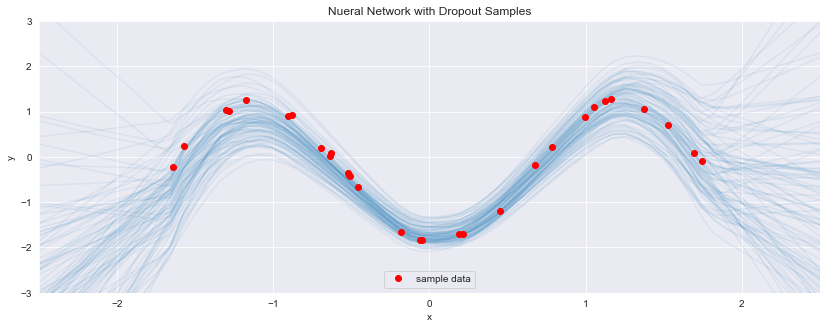

In [23]:
# Visualizing the predictive distribution samples
fig = plt.figure(figsize=(14,5))

for sample in range(len(y_pred)):
    plt.plot(X_pred, y_pred[sample], alpha=0.1, color='#4892C6')
    
plt.plot(X_tf, y_tf, color = 'r', linestyle='', marker = 'o', label = 'sample data')

    
plt.xlim(-2.5,2.5)
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nueral Network with Dropout Samples')
plt.legend()

plt.show()

In [24]:
# Computing the mean of the samples
mean_y = np.array(y_pred).mean(axis=0)

In [25]:
# Computing the variance at each point sampled
y_var = np.sqrt( tau2 + (np.array(y_pred)**2).mean(axis=0)-mean_y**2 )

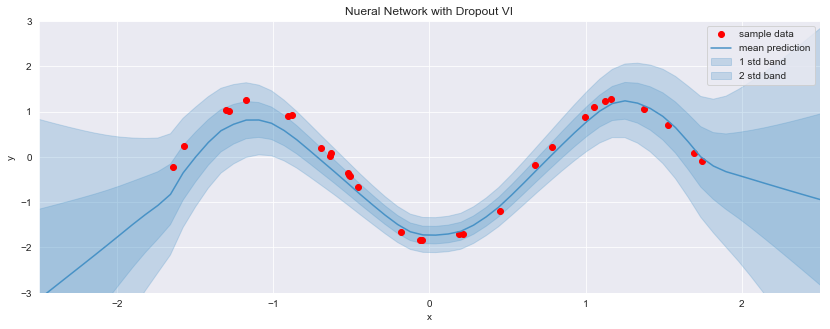

In [27]:
# Ploting the mean and standard deviation bands
fig = plt.figure(figsize=(14,5))
plt.plot(X_tf, y_tf, color ='r', linestyle='', marker = 'o', label = 'sample data')

plt.plot(X_pred, mean_y, color = '#4892C6', label='mean prediction')

plt.fill_between(X_pred.flatten(), (mean_y - 1.*y_var).flatten(), (mean_y + 1.*y_var).flatten(), color='#4892C6', alpha=0.25, label='1 std band')
plt.fill_between(X_pred.flatten(), (mean_y - 2.*y_var).flatten(), (mean_y + 2.*y_var).flatten(), color='#4892C6', alpha=0.25, label='2 std band')


plt.xlim(-2.5,2.5)
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nueral Network with Dropout VI')
plt.legend()

plt.show()

We see very similar results of the neural network with dropout as he GP with the special kernel, as is expected.

## Deep Networks

It turns out that the results still hold for an arbitrary depth network and I refer the reader to the appendix of the G&G paper if interested in the details, (https://arxiv.org/pdf/1506.02157.pdf).  

Below lets see how the analysis works for a 2 layer network with different non-linear functions.

In [45]:
tf.reset_default_graph()

# Network Architechure Parameters
H = 20  # hidden layer number of neurons
R = len(X_tf) # number of observations/records

p = 0.95 # keep the connection probability
weight_decay = 1.e-5

tau2 = 2.*R*weight_decay

input_dim = 1 # each observation, the length of the input vector
output_dim = 1 # for each observation, the length of the output vector

# tf Graph Input points
x = tf.placeholder("float", [None, input_dim])
target = tf.placeholder("float", [None, output_dim])

# Store layers weight & biases
weights = {
    'W1': tf.Variable( tf.random_normal([input_dim, H]) ),
    'W2': tf.Variable( tf.random_normal([H, H]) ),
    'Wo': tf.Variable( tf.random_normal([H, output_dim]) ),
    
    'ReW1': tf.Variable( tf.random_normal([input_dim, H]) ),
    'ReW2': tf.Variable( tf.random_normal([H, H]) ),
    'ReWo': tf.Variable( tf.random_normal([H, output_dim]) )
}

#only the one bias is used for the hidden layer, initialized to basically 0.0
biases = {
    'b1': tf.Variable( tf.random_normal([H], mean=0.0,stddev=0.0001) ),
    'b2': tf.Variable( tf.random_normal([H], mean=0.0,stddev=0.0001) ),
    
    'Reb1': tf.Variable( tf.random_normal([H], mean=0.0,stddev=0.0001) ),
    'Reb2': tf.Variable( tf.random_normal([H], mean=0.0,stddev=0.0001) )
}

# adding dropout to the weight parameters
dropped_weights = {
    'W1': tf.nn.dropout(weights['W1'],p),
    'W2': tf.nn.dropout(weights['W2'],p),
    'Wo': tf.nn.dropout(weights['Wo'],p),
    
    'ReW1': tf.nn.dropout(weights['ReW1'],p),
    'ReW2': tf.nn.dropout(weights['ReW2'],p),
    'ReWo': tf.nn.dropout(weights['ReWo'],p)
}

# we're going to apply ReLU as our non-linear sigma function on layer 1
# and apply tanh as our non-linear function on layer 2
layer_1 = tf.nn.relu( tf.add(tf.matmul(x, dropped_weights['W1']), biases['b1']) )
layer_2 = tf.nn.tanh( tf.add(tf.matmul(layer_1, dropped_weights['W2']), biases['b2']) )
output_layer = tf.matmul(layer_2, dropped_weights['Wo'])

# and as an alternative lets see what it looks like with 2 ReLU layers
layer_Relu_1 = tf.nn.relu( tf.add(tf.matmul(x, dropped_weights['ReW1']), biases['Reb1']) )
layer_Relu_2 = tf.nn.relu( tf.add(tf.matmul(layer_Relu_1, dropped_weights['ReW2']), biases['Reb2']) )
output_Relu_layer = tf.matmul(layer_Relu_2, dropped_weights['ReWo'])

# No dropout Layers
layer_1_nd = tf.nn.relu( tf.add(tf.matmul(x, weights['W1']), biases['b1']) )
layer_2_nd = tf.nn.tanh( tf.add(tf.matmul(layer_1_nd, weights['W2']), biases['b2']) )
output_layer_nd = tf.matmul(layer_2_nd, weights['Wo'])



loss_op = tf.reduce_mean( (output_layer-target)**2/2.) + \
          p*weight_decay*tf.reduce_sum(weights['W1']**2) + \
          p*weight_decay*tf.reduce_sum(weights['W2']**2) + \
          p*weight_decay*tf.reduce_sum(weights['Wo']**2) + \
          weight_decay*tf.reduce_sum(biases['b1']**2) + \
          weight_decay*tf.reduce_sum(biases['b2']**2)

loss_Relu_op = tf.reduce_mean( (output_Relu_layer-target)**2/2.) + \
          p*weight_decay*tf.reduce_sum(weights['ReW1']**2) + \
          p*weight_decay*tf.reduce_sum(weights['ReW2']**2) + \
          p*weight_decay*tf.reduce_sum(weights['ReWo']**2) + \
          weight_decay*tf.reduce_sum(biases['Reb1']**2) + \
          weight_decay*tf.reduce_sum(biases['Reb2']**2)
        
# optimizer
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss_op)
train_Relu_op = optimizer.minimize(loss_Relu_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# display the loss at each n x display_step
display_step = 1000

# Parameters for network training
num_steps = 10000

# number of samples to take from
# the predictive distribution
T = 100

# Start training session
with tf.Session() as sess:

    # Run the variables initializer
    sess.run(init)

    # the optimization loop
    for step in range(num_steps):

        # Run backprop operation
        sess.run([train_op,train_Relu_op], feed_dict={x: X_tf, target: y_tf})
        if step % display_step == 0 or step == 1:
            # Calculate loss
            loss = sess.run([loss_op,loss_Relu_op], feed_dict={x: X_tf, target: y_tf})
            print("Step " + str(step) + ", Loss = ", loss)
    
    print("Optimization Finished!")
    
    # Sampling the predictive distribution for each of the prediction points
    y_insample = sess.run(output_layer_nd, feed_dict={x: X_tf})
    y_pred = [ sess.run(output_layer, feed_dict={x: X_pred}) for _ in range(T)]
    y_Relu_pred = [ sess.run(output_Relu_layer, feed_dict={x: X_pred}) for _ in range(T)]

('Step 0, Loss = ', [16.045113, 65.142494])
('Step 1, Loss = ', [10.225726, 26.317043])
('Step 1000, Loss = ', [0.6186127, 0.079962224])
('Step 2000, Loss = ', [0.062688686, 0.048832674])
('Step 3000, Loss = ', [0.1616981, 0.021607824])
('Step 4000, Loss = ', [0.096028164, 0.03907036])
('Step 5000, Loss = ', [0.017767088, 0.032205943])
('Step 6000, Loss = ', [0.028483558, 0.10453199])
('Step 7000, Loss = ', [0.019021073, 0.021419778])
('Step 8000, Loss = ', [0.04315831, 0.13091257])
('Step 9000, Loss = ', [0.027670769, 0.021972029])
Optimization Finished!


In [46]:
# Computing the mean of the samples
mean_y = np.array(y_pred).mean(axis=0)
mean_Relu_y =  np.array(y_Relu_pred).mean(axis=0)

# Computing the variance at each point sampled
y_var = np.sqrt( tau2 + (np.array(y_pred)**2).mean(axis=0)-mean_y**2 )
y_Relu_var = np.sqrt( tau2 + (np.array(y_Relu_pred)**2).mean(axis=0)-mean_Relu_y**2 )

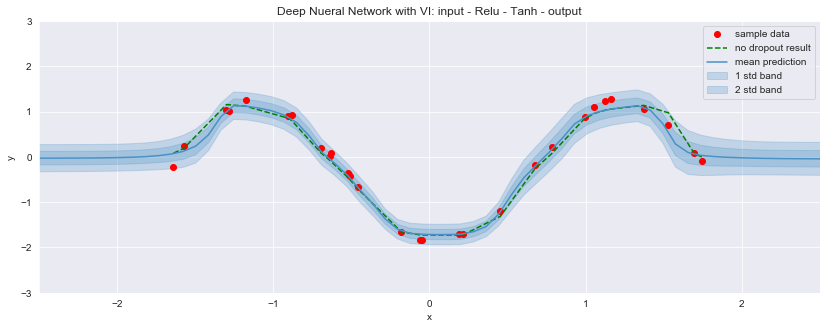

In [47]:
# Ploting the mean and standard deviation bands
fig = plt.figure(figsize=(14,5))
plt.plot(X_tf, y_tf, color = 'r', linestyle = '', marker = 'o', label = 'sample data')
plt.plot(X_tf,y_insample, color='green', linestyle='--', label='no dropout result')
plt.plot(X_pred, mean_y, color = '#4892C6', label = 'mean prediction')

plt.fill_between(X_pred.flatten(), (mean_y - 1.*y_var).flatten(), (mean_y + 1.*y_var).flatten(), alpha=0.25, color = "#4892C6", label = '1 std band')
plt.fill_between(X_pred.flatten(), (mean_y - 2.*y_var).flatten(), (mean_y + 2.*y_var).flatten(), alpha=0.25, color = "#4892C6", label = '2 std band')


plt.xlim(-2.5,2.5)
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deep Nueral Network with VI: input - Relu - Tanh - output')
plt.legend()

plt.show()

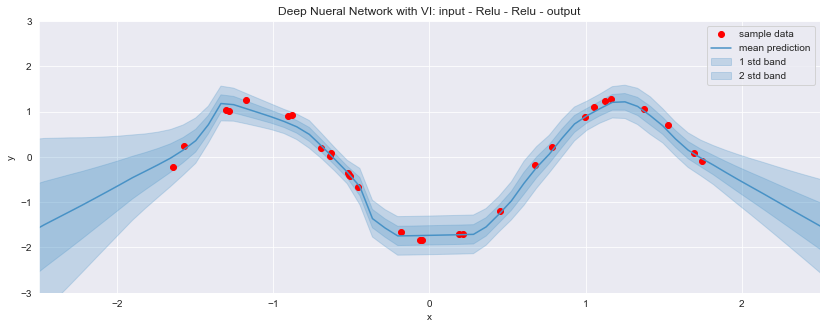

In [48]:
# Ploting the mean and standard deviation bands
fig = plt.figure(figsize=(14,5))
plt.plot(X_tf, y_tf, color = 'r', linestyle = '', marker = 'o', label = 'sample data')
plt.plot(X_pred, mean_Relu_y, color = '#4892C6', label = 'mean prediction')

plt.fill_between(X_pred.flatten(), (mean_Relu_y - 1.*y_Relu_var).flatten(), (mean_Relu_y + 1.*y_Relu_var).flatten(), alpha=0.25, color = "#4892C6", label = '1 std band')
plt.fill_between(X_pred.flatten(), (mean_Relu_y - 2.*y_Relu_var).flatten(), (mean_Relu_y + 2.*y_Relu_var).flatten(), alpha=0.25, color = "#4892C6", label = '2 std band')


plt.xlim(-2.5,2.5)
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deep Nueral Network with VI: input - Relu - Relu - output')
plt.legend()

plt.show()

## Real World Applications

These results allow us to interpret any stochastic regularization method as approximate Bayesian inference.  Real world results were created by Yarin Gal, for Mauna Loa Observatory CO2 data with a 5 layer deep 1024 node per layer fully connected net to show good results which can be seen here (http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html).  Unfortunately without a GPU, or GPU cluster recreating this on a laptop is time prohibitive.  However Yal notes that VI methods tend to UNDER estimate the variance and that improvements on the variance should be done. 

I believe combining this with LIME interpretation will allow much better adoption of deep neural nets for business type problems in the future and I look forward to further research from these two.